In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef-cs-true-fmdw-false'.format(expanduser("~"))
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

IDENTIFICATIONS_PASEF_DIR = '{}/identifications-pasef-cs-true-fmdw-false'.format(expanduser("~"))
IDENTIFICATIONS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTIFICATIONS_PASEF_DIR, experiment_name)

FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

In [24]:
def max_scan_for_mz(mz):
    scan_for_mz = max(int(-1 * ((1.2 * mz) - 1252)), 0)
    return scan_for_mz

In [27]:
max_scan_for_mz(400)

772

In [3]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_pasef_df = d['features_df']

In [4]:
MAXIMUM_Q_VALUE = 0.01

In [5]:
# load the identifications by PASEF
with open(IDENTIFICATIONS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_pasef_df = d['identifications_df']
identifications_pasef_df = identifications_pasef_df[(identifications_pasef_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

In [28]:
identifications_pasef_df.columns

Index(['mz_apex_without_saturation_correction',
       'mz_apex_with_saturation_correction', 'mz_lower', 'mz_upper',
       'scan_apex', 'scan_lower', 'scan_upper', 'rt_apex', 'rt_lower',
       'rt_upper', 'mono_intensity_without_saturation_correction',
       'mono_intensity_with_saturation_correction',
       'mono_intensity_adjustment_outcome', 'isotopic_peaks', 'scan_df',
       'rt_df', 'monoisotopic_mz', 'charge', 'monoisotopic_mass',
       'feature_intensity', 'envelope', 'isotope_count', 'deconvolution_score',
       'precursor_cuboid_id', 'fragment_ions_l', 'feature_id', 'run_name',
       'predicted_mass_error', 'recalibrated_monoisotopic_mass',
       'recalibrated_monoisotopic_mz', 'file_idx', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa', 'observed_monoisotopic_mass',
       'theoretical_peptide_mass', 'ma

In [31]:
# exclude the features/idents that were above the charge-1 line (to make consistent with what 3DID does)
identifications_pasef_df['exclude'] = identifications_pasef_df.apply(lambda row: True if row.scan_lower <= max_scan_for_mz(row.mz_apex_without_saturation_correction) else False, axis=1)

In [32]:
identifications_pasef_df['exclude'].value_counts()

False    5955
True      135
Name: exclude, dtype: int64

In [6]:
# take the best instance of a unique sequence
sequences_l = []
for group_name,group_df in identifications_pasef_df.groupby(['sequence','charge'], as_index=False):
    sequence = group_name[0]
    charge = group_name[1]
    best = group_df.loc[group_df['percolator q-value'].idxmin()]
    sequences_l.append({'feature_id':best.feature_id, 'sequence':sequence, 'charge':charge, 'score':best['percolator score'], 'q_value':best['percolator q-value']})
unique_identifications_pasef_df = pd.DataFrame(sequences_l)

In [7]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

In [8]:
print('{} detected ({} uniques identified with q-value < {}) by PASEF method, {} detected by 3DID method'.format(len(features_pasef_df), len(unique_identifications_pasef_df), MAXIMUM_Q_VALUE, len(features_3did_df)))


80838 detected (4980 uniques identified with q-value < 0.01) by PASEF method, 62028 detected by 3DID method


In [21]:
features_pasef_df.charge.value_counts()

2    68841
3     6129
4     3923
1     1167
5      778
Name: charge, dtype: int64

In [22]:
features_3did_df.charge.value_counts()

2    45538
3    10842
4     4113
5      788
1      747
Name: charge, dtype: int64

In [9]:
DUP_MZ_TOLERANCE_PPM = 5
DUP_SCAN_TOLERANCE = 2
DUP_RT_TOLERANCE = 1

In [10]:
# set up dup definitions for 3DID
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
features_3did_df['dup_mz'] = features_3did_df['monoisotopic_mz']  # shorthand to reduce verbosity
features_3did_df['dup_mz_ppm_tolerance'] = features_3did_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
features_3did_df['dup_mz_lower'] = features_3did_df.dup_mz - features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_mz_upper'] = features_3did_df.dup_mz + features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_scan_lower'] = features_3did_df.scan_apex - DUP_SCAN_TOLERANCE
features_3did_df['dup_scan_upper'] = features_3did_df.scan_apex + DUP_SCAN_TOLERANCE
features_3did_df['dup_rt_lower'] = features_3did_df.rt_apex - DUP_RT_TOLERANCE
features_3did_df['dup_rt_upper'] = features_3did_df.rt_apex + DUP_RT_TOLERANCE

In [11]:
# set up dup definitions for PASEF
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
features_pasef_df['dup_mz'] = features_pasef_df['monoisotopic_mz']  # shorthand to reduce verbosity
features_pasef_df['dup_mz_ppm_tolerance'] = features_pasef_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
features_pasef_df['dup_mz_lower'] = features_pasef_df.dup_mz - features_pasef_df.dup_mz_ppm_tolerance
features_pasef_df['dup_mz_upper'] = features_pasef_df.dup_mz + features_pasef_df.dup_mz_ppm_tolerance
features_pasef_df['dup_scan_lower'] = features_pasef_df.scan_apex - DUP_SCAN_TOLERANCE
features_pasef_df['dup_scan_upper'] = features_pasef_df.scan_apex + DUP_SCAN_TOLERANCE
features_pasef_df['dup_rt_lower'] = features_pasef_df.rt_apex - DUP_RT_TOLERANCE
features_pasef_df['dup_rt_upper'] = features_pasef_df.rt_apex + DUP_RT_TOLERANCE

In [12]:
features_3did_df.columns

Index(['mz_apex_without_saturation_correction',
       'mz_apex_with_saturation_correction', 'mz_lower', 'mz_upper',
       'scan_apex', 'scan_lower', 'scan_upper', 'rt_apex', 'rt_lower',
       'rt_upper', 'mono_intensity_without_saturation_correction',
       'mono_intensity_with_saturation_correction',
       'mono_intensity_adjustment_outcome', 'isotopic_peaks', 'scan_df',
       'rt_df', 'monoisotopic_mz', 'charge', 'monoisotopic_mass',
       'feature_intensity', 'envelope', 'isotope_count', 'deconvolution_score',
       'precursor_cuboid_id', 'fragment_ions_l', 'feature_id', 'run_name',
       'dup_mz', 'dup_mz_ppm_tolerance', 'dup_mz_lower', 'dup_mz_upper',
       'dup_scan_lower', 'dup_scan_upper', 'dup_rt_lower', 'dup_rt_upper'],
      dtype='object')

In [13]:
features_pasef_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)
features_3did_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)

In [14]:
# find whether a feature detected by PASEF was also detected by 3DID
common_l = []
for row in features_pasef_df.itertuples():
    df = features_3did_df[(features_3did_df.charge == row.charge) & (features_3did_df.dup_mz > row.dup_mz_lower) & (features_3did_df.dup_mz < row.dup_mz_upper) & (features_3did_df.scan_apex > row.dup_scan_lower) & (features_3did_df.scan_apex < row.dup_scan_upper) & (features_3did_df.rt_apex > row.dup_rt_lower) & (features_3did_df.rt_apex < row.dup_rt_upper)].copy()
    if len(df) > 0:
        common_l.append(
            {
                'feature_id_pasef':row.feature_id, 
                'deconv_score_pasef':row.deconvolution_score,
                'feature_intensity_pasef':row.feature_intensity,
                'feature_id_3did':df.iloc[0].feature_id, 
                'deconv_score_3did':df.iloc[0].deconvolution_score,
                'feature_intensity_3did':df.iloc[0].feature_intensity
            }
        )
common_df = pd.DataFrame(common_l)

In [15]:
common_df

,feature_id_pasef,deconv_score_pasef,feature_intensity_pasef,feature_id_3did,deconv_score_3did,feature_intensity_3did
0,4201402,7950.768140,2470352,4934102,8034.788916,2369345
1,4022902,7167.560053,2355634,5456803,10099.115730,5038190
2,4256503,6688.417228,3243078,5456301,6902.283550,3499218
3,1755703,6341.592659,5979336,1780401,6385.548202,5984135
4,1258202,6244.506548,3657229,4713801,6372.979491,3797565
...,...,...,...,...,...,...
12548,3700001,174.087001,6649,11101,147.124423,5834
12549,2029801,173.729193,4978,72701,147.163543,4377
12550,921801,165.883396,5041,11001,121.103134,3519
12551,3678601,136.978021,3292,25101,111.639283,2534


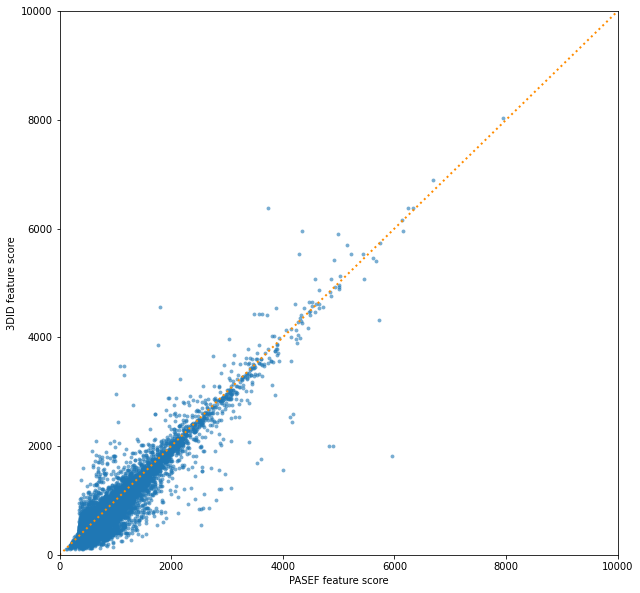

In [16]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('')

ax.scatter(common_df.deconv_score_pasef, common_df.deconv_score_3did, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,10000))
plt.ylim((-1,10000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

#### of the features identified by PASEF, how many were also detected by 3DID?

In [17]:
features_3did_identified_df = pd.merge(unique_identifications_pasef_df, common_df, how='inner', left_on=['feature_id'], right_on=['feature_id_pasef'])


In [18]:
features_3did_identified_df.sample(n=5)

,feature_id,sequence,charge,score,q_value,feature_id_pasef,deconv_score_pasef,feature_intensity_pasef,feature_id_3did,deconv_score_3did,feature_intensity_3did
1723,3210901,QSLGELIGTLNAAK,2,0.396979,0.000493,3210901,1140.330324,156511,1052301,1076.763000,156634
1731,2491704,QTTADFLTSVTSPSER,2,0.193755,0.000949,2491704,782.538565,56281,3172103,709.051804,55523
92,2361803,ALEHFTDLYDIK,2,0.737031,0.000287,2361803,864.602718,102810,1296001,814.545782,100685
1835,4044902,SAMQSVVDDWIESYK,2,0.624516,0.000287,4044902,789.119223,67805,3184801,395.719678,67940
65,3912503,AGSGTSQLDQLAALQALSSSLNK,2,0.885868,0.000287,3912503,959.276586,63988,5863401,853.161410,56054


In [19]:
len(features_3did_identified_df)

2516

In [20]:
len(unique_identifications_pasef_df)

4980